# Variational Auto Encoder: integration with PyMC3

requirements

+ theano >= 0.9.0
+ pymc3 >= 3.1.0


referrence

+ paper http://arxiv.org/abs/1312.6114
+ pymc3+keras example http://pymc-devs.github.io/pymc3/notebooks/convolutional_vae_keras_advi.html

In [1]:
from collections import OrderedDict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pymc3 as pm
import theano
import theano.tensor as tt
from torchvision import datasets

import t721.leaf as L

/home/skarita/.pyenv/versions/anaconda3-4.3.0/envs/tf/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:03:00.0)


In [2]:
# loading dataset
train_mnist = datasets.MNIST('./data', train=True, download=True)
x_train = train_mnist.train_data.numpy()
data = pm.floatX(x_train.reshape(-1, 1, 28, 28))
data /= 255.0

In [3]:
class ConvVAE(L.Leaf):
    def __init__(self, n_latent, n_hidden=128, n_filters=64):
        self.act = tt.nnet.relu
        self.n_filters = n_filters

        # params for encode
        self.conv1 = L.Conv2D(1, n_filters, kernel=(3, 3))
        self.conv2 = L.Conv2D(n_filters, n_filters, kernel=(1, 1))
        self.conv3 = L.Conv2D(n_filters, n_filters, kernel=(3, 3))
        input_shape = (1, 1, 28, 28)
        self.conved_shape = L.get_output_shape(input_shape, [self.conv1, self.conv2, self.conv3])
        n_out = numpy.prod(self.conved_shape)
        self.fc1 = L.Linear(n_out, n_hidden)
        self.fc2 = L.Linear(n_hidden, n_latent * 2)

        # params for decode
        self.dfc1 = L.Linear(n_latent, n_hidden)
        self.dfc2 = L.Linear(n_hidden, n_out)
        self.dconv1 = L.Deconv2D(n_filters, n_filters, kernel=(3, 3))
        self.dconv2 = L.Deconv2D(n_filters, n_filters, kernel=(1, 1))
        self.dconv3 = L.Deconv2D(n_filters, 1, kernel=(3, 3))
        output_shape = L.get_output_shape(self.conved_shape, [self.dconv1, self.dconv2, self.dconv3])
        assert input_shape == output_shape

    def encode(self, xs):
        h = self.act(self.conv1(xs))
        h = self.act(self.conv2(h))
        h = self.act(self.conv3(h))
        h = h.reshape([xs.shape[0], -1])
        h = self.act(self.fc1(h))
        encoded = self.fc2(h)
        return tt.split(encoded, [n_latent] * 2, 2, axis=1)

    def decode(self, zs):
        h = self.act(self.dfc1(zs))
        h = self.act(self.dfc2(h))
        h = h.reshape([zs.shape[0], *self.conved_shape[1:]])
        h = self.act(self.dconv1(h))
        h = self.act(self.dconv2(h))
        h = self.dconv3(h)
        return tt.nnet.sigmoid(h)

## Problem definition

Marginal log-likelihood of i.i.d. dataset $x^{(1)}, \dots, x^{(I)}$ and generative model $p_{\theta}(x)$ is $\log p_{\theta} (x^{(1)}, \dots, x^{(I)}) = \sum_{i} \log p_{\theta}(x^{(i)}) $, and the each factor can be rewritten as:

\begin{align}
  \log p_{\theta}(x^{(i)}) &= \log p_{\theta}(x^{(i)}) \int_{z} q(z) dz \\
  &= \mathrm{KL}(q_\phi(z) || p_\theta(z|x^{(i)}) ) + \int_z q_\phi(z) \log \frac{p_\theta(z|x^{(i)})}{q_\phi(z)} dz  + \int_{z} q(z)  \log p(x^{(i)}) dz \\
  &= \mathrm{KL}(q_\phi(z) || p_\theta(z|x^{(i)}) ) + \mathbf{E}_{q_\phi(z)} \left[ -\log q_\phi(z) + \log p_\theta(x^{(i)}, z) \right] \\
\end{align}

Using Gibbs inequality (KL divergence is always non negative)

\begin{align}
  \log p_{\theta}(x^{(i)}) 
  &= \mathrm{KL}(q_\phi(z) || p_{\theta}(z | x^{(i)})) + \mathbf{E}_{q_\phi(z)} \left[ -\log q_\phi(z) + \log p_\theta(x^{(i)}, z) \right] \\
  &\geq \mathbf{E}_{q_\phi(z)} \left[ -\log q_\phi(z) + \log p_\theta(x^{(i)}, z) \right] 
\\
  &\approx \frac{1}{J} \sum_{j=1}^{J}  \left\{ -\log q_\phi(z^{(j)}) + \log p_\theta(x^{(i)}, z^{(j)}) \right\}
\end{align}

where,
+ $z^{(j)}$ is sampled from $q_\phi(z)$ (Monte-Carlo approximation)
+ $q_\phi(z) $ can be $q_\phi(z|x^{(i)})$ (e.g., mixture density network)
+ $\theta$ generative parameters
+ $\phi$ variational parameters

This lower-bould is known as the variational lower bound or evidence lower bound (ELBO).


### Stochastic Gradient Variational Bayes (SGVB) estimator

In variational auto-encoder (VAE), considering only the computable KL-divergence of **prior**  $\text{KL}(q_\phi(z) || p_\theta(z) )$ (e.g., standard normal distribution) 

\begin{align}
  \mathbf{E}_{q_\phi(z)} \left[ -\log q_\phi(z) + \log p_\theta(x^{(i)}, z) \right] 
  &= \mathbf{E}_{q_\phi(z)} \left[ -\log \frac{q_\phi(z)}{p_\theta(z)} + \log \frac{p_\theta(x^{(i)}, z)}{p_\theta(z)} \right] \\
  &= - \text{KL}(q_\phi(z) || p_\theta(z) ) +  \mathbf{E}_{q_\phi(z)} \left[ \log p_\theta(x^{(i)}| z) \right] 
\end{align}

using Monte-Carlo sampling approximation $ \frac{1}{J} \sum_{j}  \log p_{\theta}(x^{(i)} | z^{(i, j)}) \approx \mathrm{E}_{q_\phi(z)}\left[ \log \frac{p_\theta(x^{(i)}, z)}{q_\phi(z)}  \right]$ as follows:

$$
\tilde{L}(\theta, \phi, x^{(i)}) = -\mathrm{KL}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) + \frac{1}{J} \sum_{j} \log p_{\theta}(x^{(i)} | z^{(i, j)})
$$
where
+ $J$ is a number of sampling. (it can be 1 if minibatch is large)
+ $z^{(i,j)} = \mathrm{Encoder}_{\phi}(e^{(i,j)}, x^{(i)})$ and $e ^{(i,j)} \sim p(e)$
+ in this paper, diagonal Gaussian for $q_{\phi}(z|x^{(i)}), p_{\theta}(z)$ is the simplest analytical case

In [4]:
# building model
n_latent = 2
n_batch = 64

vae = ConvVAE(n_latent)
xs = tt.tensor4("xs")
xs.tag.test_value = numpy.zeros((n_batch, 1, 28, 28)).astype('float32')

with pm.Model() as model:
    zs = pm.Normal("zs", mu=0, sd=1, shape=(n_batch, n_latent),  # stochastic auxualy input p(z)
                   dtype=theano.config.floatX, total_size=len(data))
    xs_ = pm.Normal("xs_", mu=vae.decode(zs), sd=0.1, observed=xs, # reconstruction of xs, p(x|z), why sd=0.1?
                    dtype=theano.config.floatX, total_size=len(data))

In [5]:
# fitting model
mean, stddev = vae.encode(xs)
local_RVs = OrderedDict({zs: (mean, stddev)})  # encoded stochastic variable q(z|x)
xs_minibatch = pm.Minibatch(data, n_batch)

with model:
    approx = pm.fit(10000, local_rv=local_RVs,
                    obj_optimizer=pm.adam(learning_rate=1e-4),
                    more_obj_params=list(vae.get_params()),
                    more_replacements={xs: xs_minibatch})

Average Loss = 2.8484e+07: 100%|██████████| 10000/10000 [03:41<00:00, 45.10it/s]
Finished [100%]: Average Loss = 2.8459e+07


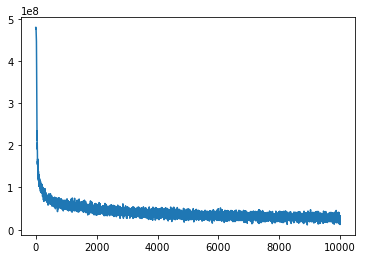

In [6]:
img = plt.plot(approx.hist)

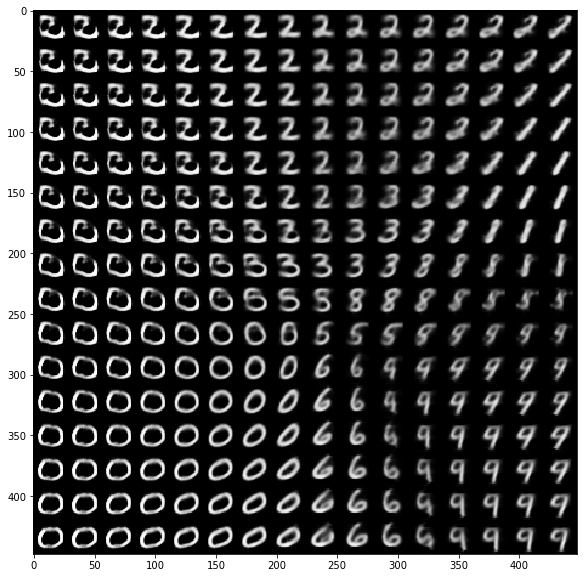

In [7]:
# evaluate decoder
dec_zs = tt.matrix()
dec_fun = theano.function([dec_zs], theano.clone(vae.decode(zs), {zs: dec_zs}))

nn = 16
nzs = numpy.array([(z1, z2)
                  for z1 in numpy.linspace(-2, 2, nn)
                  for z2 in numpy.linspace(-2, 2, nn)]).astype('float32')
nxs = dec_fun(nzs)[:, 0, :, :]
nxs = numpy.bmat([[nxs[i + j * nn] for i in range(nn)] for j in range(nn)])
matplotlib.rc('axes', **{'grid': False})
plt.figure(figsize=(10, 10))
img = plt.imshow(nxs, interpolation='none', cmap='gray')

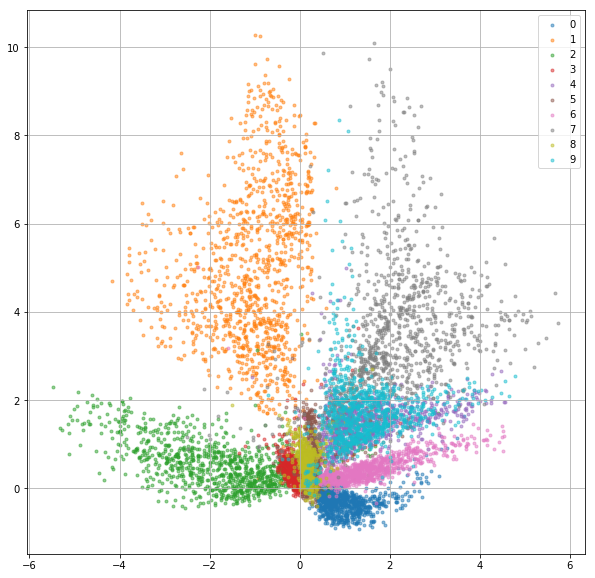

In [8]:
# evaluate encoder
enc_xs = tt.tensor4("enc_xs")
enc_xs.tag.test_value = data[:1]
enc_fun = theano.function([enc_xs], theano.clone(vae.encode(enc_xs)[0]))

test_mnist = datasets.MNIST('./data', train=False, download=True)
test = [[] for i in range(10)]
for x, t in test_mnist:
    test[t].append(x)

plt.figure(figsize=(10, 10))
ps = []
for xs in test:
    x_sample = numpy.stack(xs).astype(theano.config.floatX).reshape(-1, 1, 28, 28)
    z_mu = enc_fun(x_sample / 255.0)
    ps.append(plt.scatter(z_mu[:, 0], z_mu[:, 1], alpha=0.5, marker="."))

plt.legend(ps, range(10))
plt.grid()

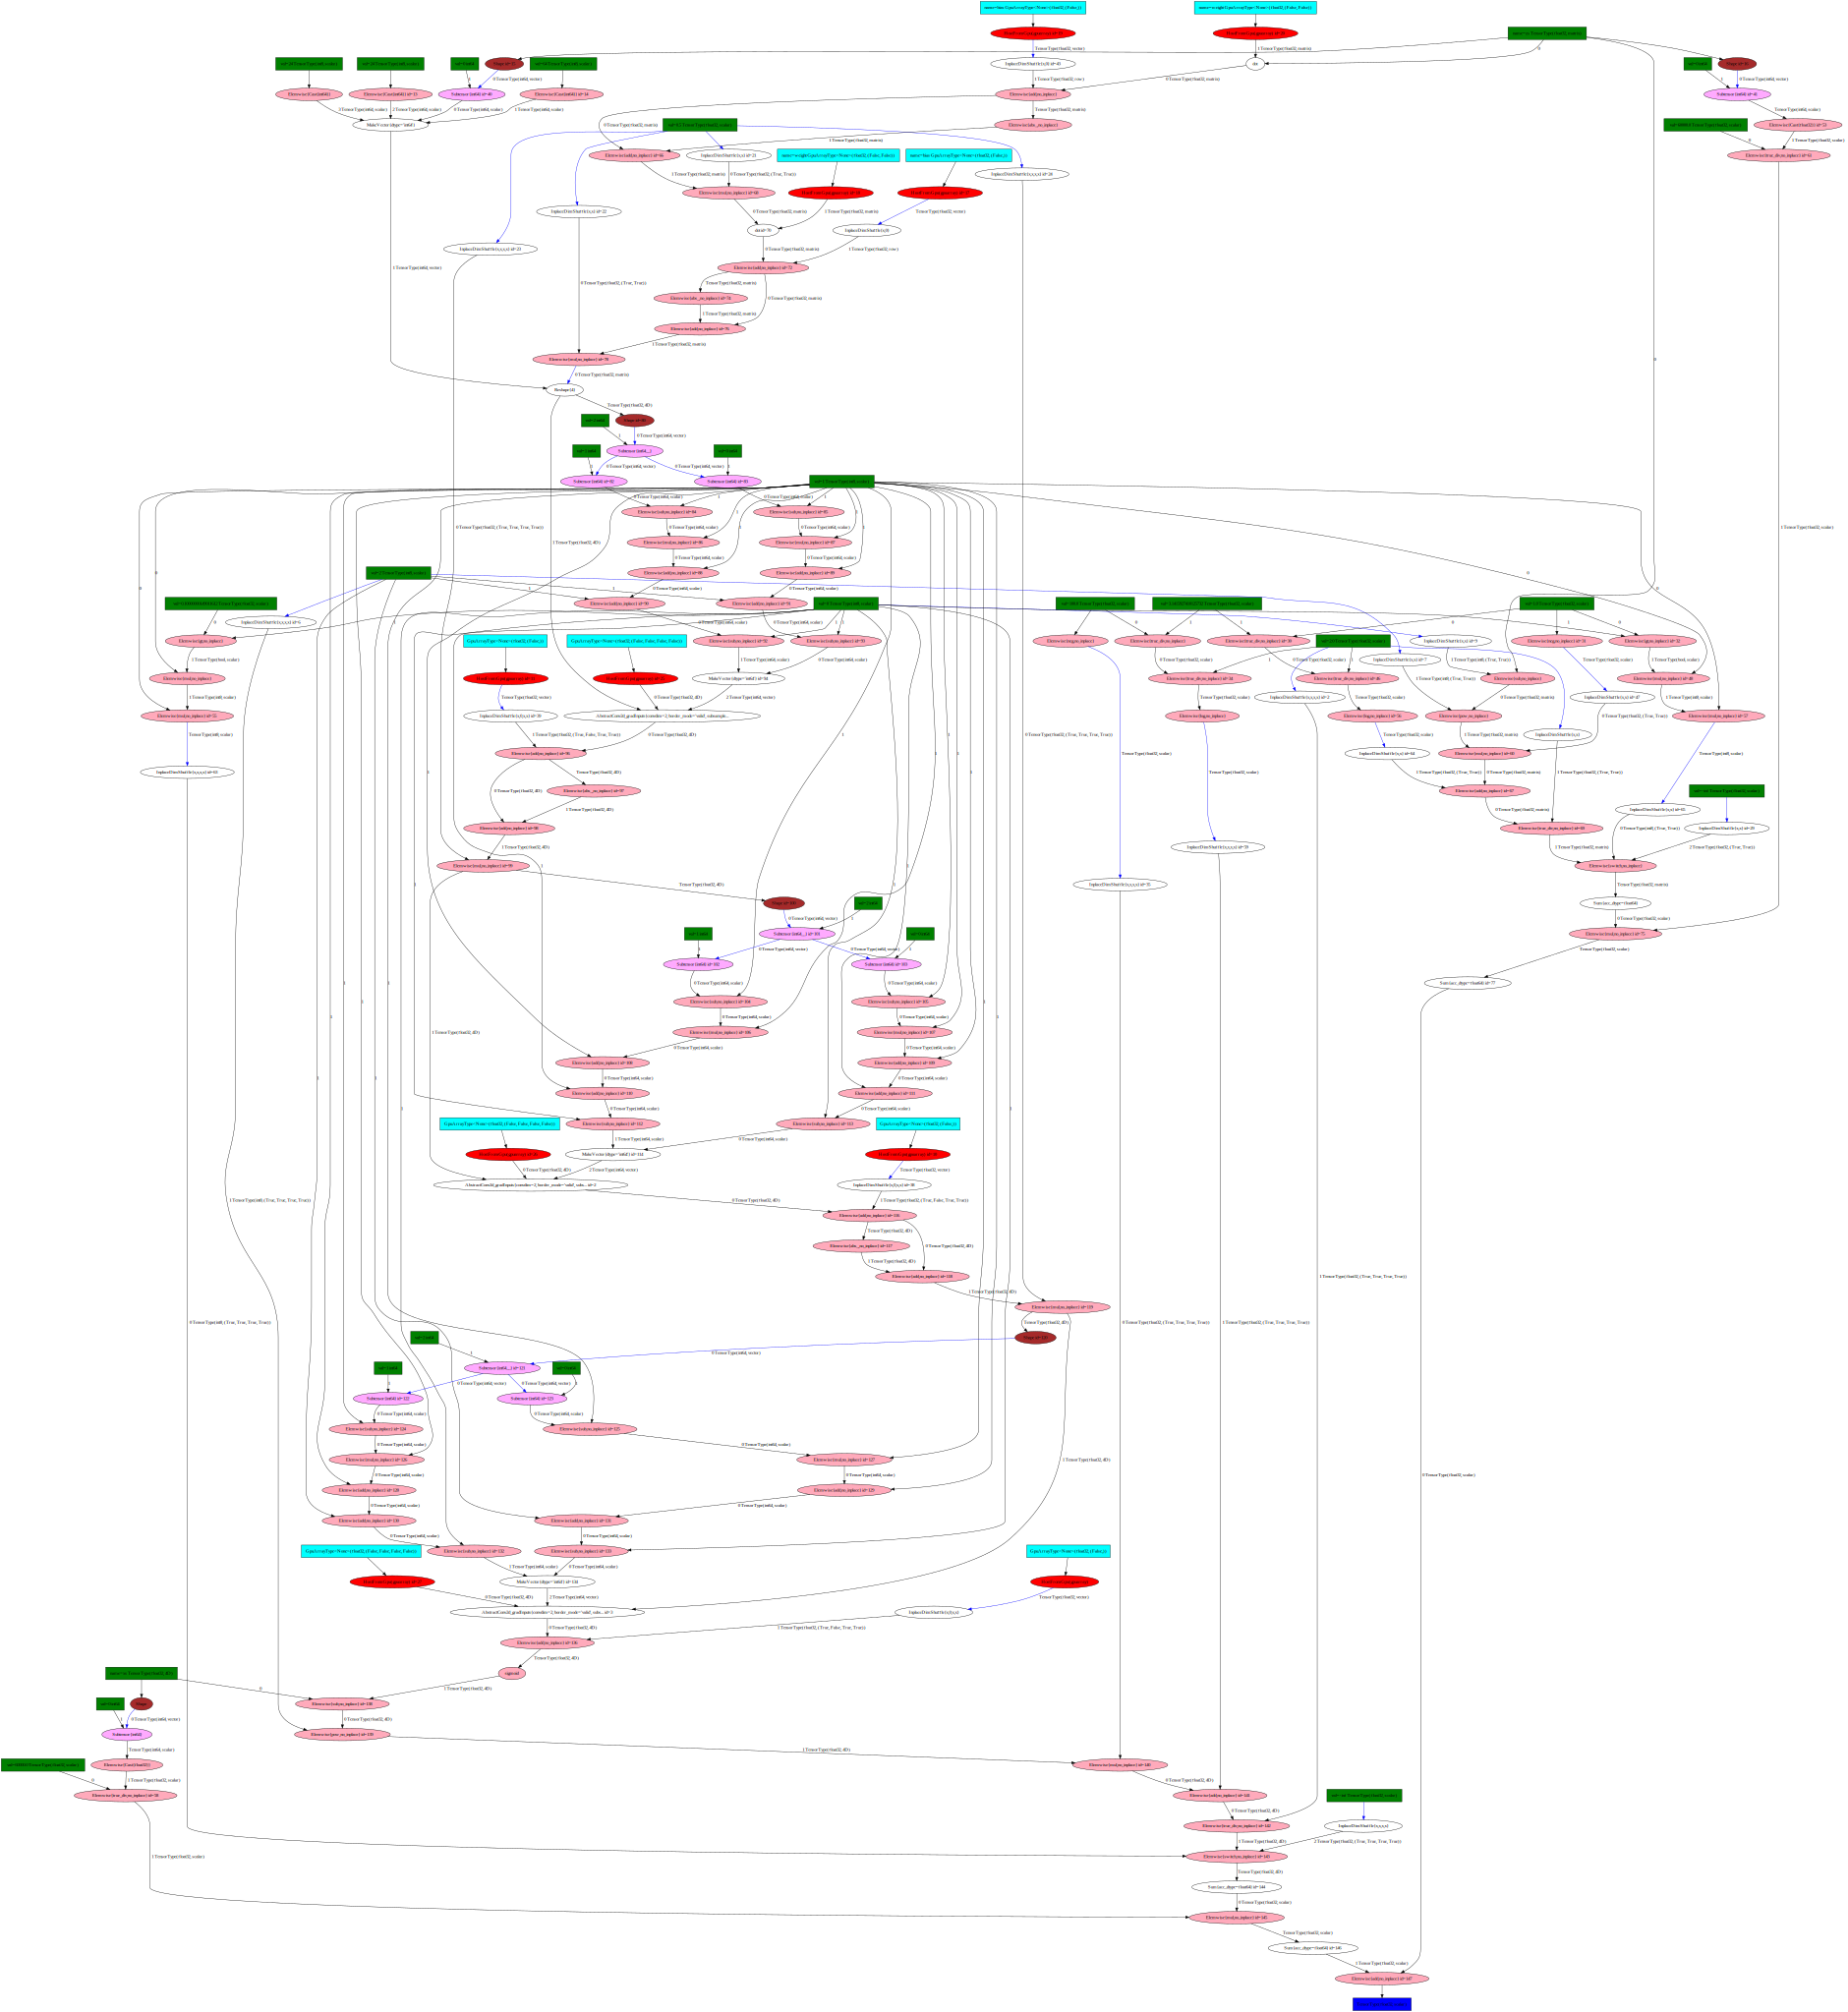

In [9]:
from IPython.display import SVG
SVG(theano.printing.pydotprint(model.logpt, return_image=True, format="svg"))